In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models import RNNGC
from dataset import DatasetMaker

In [2]:
samples = 1000
timesteps = 10

In [3]:
model = RNNGC()
model = model.load("./best_models/RNNGC.pkl")

In [4]:
dataset = DatasetMaker()

In [5]:
r, v = dataset.generate_data(samples, timesteps)
g = model((r[:,0], v))
loss = model.similarity_loss(g[:,-1], r[:,-1])

In [6]:
grads = torch.autograd.grad(loss, g)[0]
grads.shape

torch.Size([1000, 10, 256])

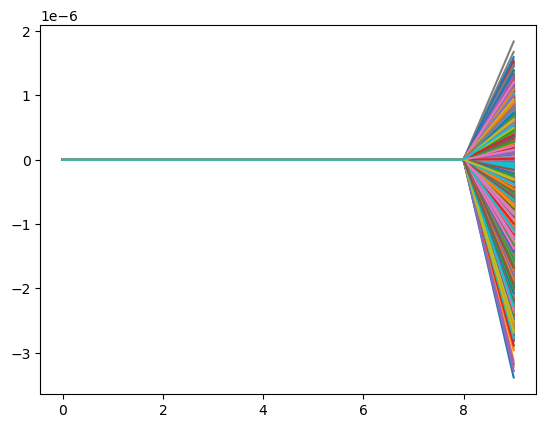

In [10]:
for i in range(8):
    plt.plot(grads.detach().numpy()[...,i].T);

In [8]:
''

''